# Introduction #

Welcome to the feature engineering project for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition! This competition uses nearly the same data you used in the exercises of the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course. We'll collect together the work you did into a complete project which you can build off of with ideas of your own.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

# Step 1 - Preliminaries #
## Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [1]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [2]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Clean Data ###

Some of the categorical features in this dataset have what are apparently typos in their categories:

In [3]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

Comparing these to `data_description.txt` shows us what needs cleaning. We'll take care of a couple of issues here, but you might want to evaluate this data further.

In [4]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This hidden cell defines the `encode` function:

In [5]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [6]:
def impute(df):
    for name in df.select_dtypes("number"):

# I found adding features for numerical missing values was useful for 
# random forest, but not for XGBoost.
        #df[name + "_missing_value"] = 0
        #for i,a in enumerate(df[name]):
         #    if np.isnan(a):
          #            df.loc[i, name + "_missing_value"] = 1
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
# I did not find adding features for nominal missing values useful for either
# random forest or for XGBoost.
        #df[name + "_missing_value"] = 0
        df[name] = df[name].fillna("None")
        #for i,a in enumerate(df[name]):
         #   if a == "None":
          #         df.loc[i, name + "_missing_value"] = 1
    return df


***Please Note:*** I tried creating "missing value" indicators: 1 whenever a value was imputed and 0 otherwise. I tried to do so for both numerical and/or categorical features with missing values, for both the XGBoost model and for the RandomForest model. The resultant RMSLE scores are presented below. The RMSLE was lowest (best) for the RandomForest model, when missing values indicators were created only for numerical features, not for categorical features, see RMSLE table below.

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [7]:
df_train, df_test = load_data()

Uncomment and run this cell if you'd like to see what they contain. Notice that `df_test` is
missing values for `SalePrice`. (`NA`s were willed with 0's in the imputation step.)

In [8]:
# LogLotFrontage = np.log(df_train.LotFrontage)
# LogLotFrontage.hist()

In [9]:
# Peek at the values
display(df_train)
display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
display(df_test.info())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,6,2010,WD,Normal,0.0
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Gar2,12500,6,2010,WD,Normal,0.0
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,3,2010,WD,Normal,0.0
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2010,WD,Normal,0.0
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,0,None,None,None,0,1,2010,WD,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2006,WD,Normal,0.0
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2006,WD,Abnorml,0.0
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2006,WD,Abnorml,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       145

None

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.


In [10]:
# from sklearn.ensemble import RandomForestRegressor

# from sklearn.preprocessing import OneHotEncoder


#def score_dataset(X, y, model=RandomForestRegressor(random_state = 0)):
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    
    # I tried one-hot encoding for the RandomForest model 
    # for low-cardinality features.
    # low_cardinality_cols = [cname for cname in X.columns if 
    #                          X[cname].nunique() < 10 and
     #                         cname in X.select_dtypes(["category"])]
    #high_cardinality_cols = [cname for cname in X.columns if 
#                               X[cname].nunique() >= 10 and
#                               cname in X.select_dtypes(["category"])]
    
    # one-hot encoding using pd.get_dummies
    #one_hot_encoded_cols = pd.get_dummies(X[low_cardinality_cols])
    
    # one-hot encoding using OneHotEncoder
    #OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    #OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[low_cardinality_cols]))
    
    # One-hot encoding removed index; put it back
    #OH_cols.index = X.index
    
    # Remove categorical columns (will replace with one-hot encoding)
    #num_X = X.drop(low_cardinality_cols, axis=1)
    
    # Add one-hot encoded columns to numerical features
    #X = pd.concat([num_X, OH_cols], axis=1)
    
    #for colname in X[high_cardinality_cols]:
     #     X[colname] = X[colname].cat.codes
    #X.drop(low_cardinality_cols, inplace = True, axis = 1)
    #X = pd.concat([X, one_hot_encoded_cols], axis = 1)
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


I tried one-hot encoding for low-cardinality columns for the **Lasso** and **Ridge** models. The code below is commented, as these models yielded higher RMSLE scores in comparison with RandomForest, see RMSLE table below.

In [11]:
# This cell is commented and was previously used for running 
# the Lasso and Ridge models.

# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import OneHotEncoder

# This function uses the Ridge model, and adds one-hot encoding
# for low-cardinality columns.

#def score_dataset(X, y, model=Ridge()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
   # low_cardinality_cols = [cname for cname in X.columns if 
    #                           X[cname].nunique() < 10 and
     #                          cname in X.select_dtypes(["category"])]
    #high_cardinality_cols = [cname for cname in X.columns if 
     #                          X[cname].nunique() >= 10 and
      #                         cname in X.select_dtypes(["category"])]
    
    # one-hot encoding using pd.get_dummies
    #one_hot_encoded_cols = pd.get_dummies(X[low_cardinality_cols])
    
    # one-hot encoding using OneHotEncoder
    #OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    #OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[low_cardinality_cols]))
    
    # One-hot encoding removed index; put it back
    #OH_cols.index = X.index
    
    # Remove categorical columns (will replace with one-hot encoding)
    #num_X = X.drop(low_cardinality_cols, axis=1)
    
    # Add one-hot encoded columns to numerical features
    #X = pd.concat([num_X, OH_cols], axis=1)
    
    #for colname in X[high_cardinality_cols]:
     #      X[colname] = X[colname].cat.codes
    #X.drop(low_cardinality_cols, inplace = True, axis = 1)
    #X = pd.concat([X, one_hot_encoded_cols], axis = 1)
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    #log_y = np.log(y)
    #score = cross_val_score(
     #  model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    #)
    #score = -1 * score.mean()
    #score = np.sqrt(score)
    #return score

**Please note**: I tried both `pd.get_dummies` and `OneHotEncoder` in order to perform one-hot encoding for Ridge and Lasso models. Those two methods of one-hot encoding acheived exactly the same RMSLE for these two models, the RMSLE for these two models is shown in the RMSLE table displayed below.

We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [12]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


RMSLE scores acheived with different models for the baseline model, ordered from lowest to highest RMSLE, are displayed below. 
  
**Please note**: For reproducibility reasons, `random_state = 0` was used for all models based on the `RandomForestRegressor`.

## **RMSLE Table**

In [13]:
d = {'Model': ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',\
               'RandomForest', 'RandomForest', 'RandomForest', 'RandomForest',\
               'RandomForest', 'RandomForest',\
               'Lasso', 'Ridge'],\
     'Missing values indicators': ['None', 'Categorical', 'Numerical',\
                                  'Categorical and Numerical', 'None', 'Categorical', 'Numerical',\
                                  'Categorical and Numerical', 'None',\
                                   'Numerical', 'None', 'None'],\
     'One-hot encoding': ['No', 'No', 'No', 'No', 'No', 'No',\
                         'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes'], 'RMSLE': \
    [0.14351, 0.14362, 0.14414, 0.14401, 0.13997,\
    0.14022, 0.13897, 0.13950, 0.14158, 0.14220, \
    0.20100, 0.15413]}
df1 = pd.DataFrame(d)
display(df1.sort_values(by = 'RMSLE'))

,Model,Missing values indicators,One-hot encoding,RMSLE
6,RandomForest,Numerical,No,0.13897
7,RandomForest,Categorical and Numerical,No,0.13950
4,RandomForest,None,No,0.13997
5,RandomForest,Categorical,No,0.14022
8,RandomForest,None,Yes,0.14158
9,RandomForest,Numerical,Yes,0.14220
0,XGBoost,None,No,0.14351
1,XGBoost,Categorical,No,0.14362
3,XGBoost,Categorical and Numerical,No,0.14401
2,XGBoost,Numerical,No,0.14414


The lowest RMSLE for the baseline model, 0.13897, was acheived with the RandomForestRegressor, with missing values indicators used for numerical features only, and without one-hot encoding.

This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

In Lesson 2 we saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`: 

In [14]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [15]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). As we talked about in Tutorial 2, the top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [16]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


Removing them does lead to a modest performance gain:

In [17]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.14338026718687277

Later, we'll add the `drop_uninformative` function to our feature-creation pipeline.

# Step 3 - Create Features #

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

```
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X
```

Let's go ahead and define one transformation now, a [label encoding](https://www.kaggle.com/alexisbcook/categorical-variables) for the categorical features:

In [18]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If you wanted to try a linear regression model (also popular in this competition), you would instead want to use a one-hot encoding, especially for the features with unordered categories.

## Create Features with Pandas ##

This cell reproduces the work you did in Exercise 3, where you applied strategies for creating features in Pandas. Modify or add to these functions to try out other feature combinations.

**Histograms** for some of the features are presented below, in order to observe the distirbution pattern of these features.

<AxesSubplot:>

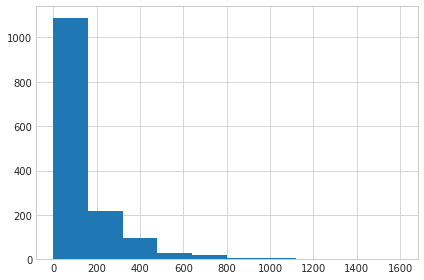

In [19]:
df_train.MasVnrArea.hist()

(array([919., 417., 114.,   8.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([   0. ,  564.4, 1128.8, 1693.2, 2257.6, 2822. , 3386.4, 3950.8,
        4515.2, 5079.6, 5644. ]),
 <BarContainer object of 10 artists>)

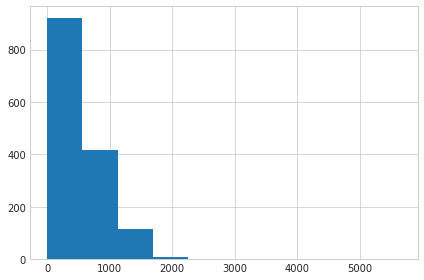

In [20]:
plt.hist(df_train.BsmtFinSF1)

<AxesSubplot:>

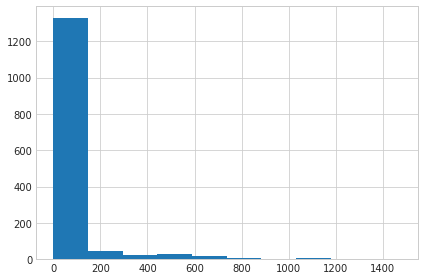

In [21]:
df_train.BsmtFinSF2.hist()

<AxesSubplot:>

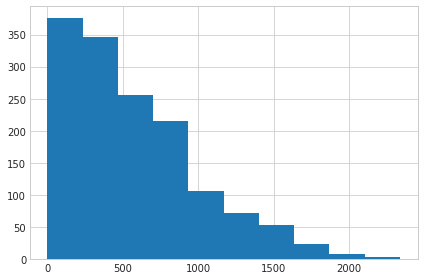

In [22]:
df_train.BsmtUnfSF.hist()

<AxesSubplot:>

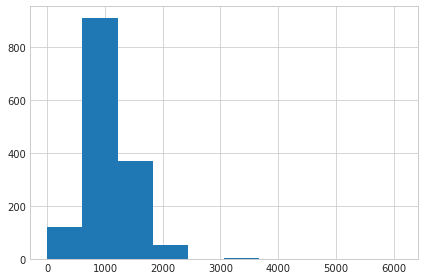

In [23]:
df_train.TotalBsmtSF.hist()

<AxesSubplot:>

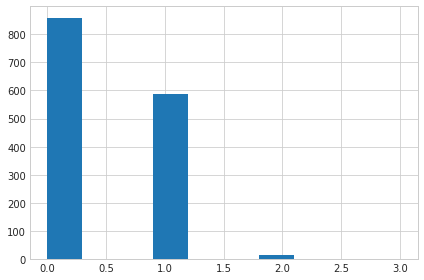

In [24]:
df_train.BsmtFullBath.hist()

<AxesSubplot:>

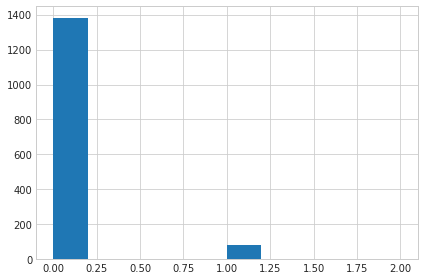

In [25]:
df_train.BsmtHalfBath.hist()

The numerical features of dtype `float64` are presented below.

In [26]:
df_train.dtypes[df_train.dtypes == "float64"]

LotFrontage     float64
MasVnrArea      float64
BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageYrBlt     float64
GarageCars      float64
GarageArea      float64
SalePrice       float64
dtype: object

<AxesSubplot:>

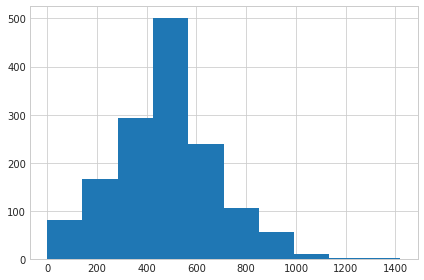

In [27]:
df_train.GarageArea.hist()

<AxesSubplot:>

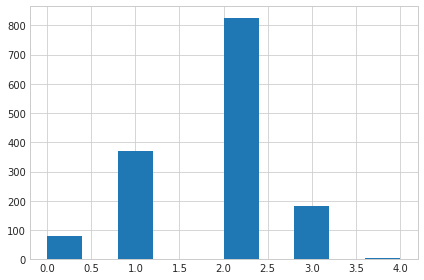

In [28]:
df_train.GarageCars.hist()

<AxesSubplot:>

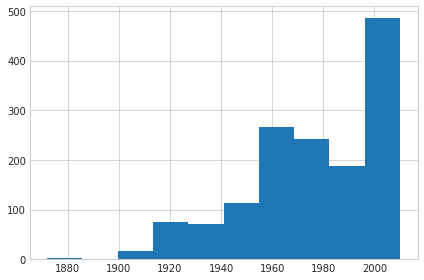

In [29]:
df_train.GarageYrBlt.hist()

In [30]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    
    # The following mathematical transformations were added by myself.
    
    # A feature incorporating OverallCond with OverallQual
    X["Overall"] = df.OverallCond.cat.codes * df.OverallQual.cat.codes
    
    # Features for feet - instead of square feet
    X["LotF"] = np.sqrt(df.LotArea)
    X["MasVnrF"] = np.sqrt(df.MasVnrArea)
    X["BsmtFin1F"] = np.sqrt(df.BsmtFinSF1)
    X["BsmtFin2F"] = np.sqrt(df.BsmtFinSF2)
    X["BsmtUnfF"] = np.sqrt(df.BsmtUnfSF)
    X["TotalBsmtF"] = np.sqrt(df.TotalBsmtSF)
    X["FirstFlrF"] = np.sqrt(df.FirstFlrSF)
    X["SecondFlrF"] = np.sqrt(df.SecondFlrSF)
    X["GrLivF"] = np.sqrt(df.GrLivArea)
    X["GarageF"] = np.sqrt(df.GarageArea)
    X["WoodDeckF"] = np.sqrt(df.WoodDeckSF)
    X["OpenPorchF"] = np.sqrt(df.OpenPorchSF)
    X["EnclosedPorchF"] = np.sqrt(df.EnclosedPorch)
    X["ThreeseasonporchF"] = np.sqrt(df.Threeseasonporch)
    X["ScreenPorchF"] = np.sqrt(df.ScreenPorch)
    X["PoolAreaF"] = np.sqrt(df.PoolArea)
    
    # Log transforms of skewed numerical features,
    # See histograms above for these features.
    X["LotFrontageLog"] = np.log(df.LotFrontage + 1)
    X["MasVnrAreaLog"] = np.log(df.MasVnrArea + 1)
    X["BsmtFinSF1Log"] = np.log(df.BsmtFinSF1 + 1)
    X["BsmtFinSF2Log"] = np.log(df.BsmtFinSF2 + 1)
    X["BsmtUnfSFLog"] = np.log(df.BsmtUnfSF + 1)
    X["TotalBsmtSFLog"] = np.log(df.TotalBsmtSF + 1)
    #X["BsmtFullBathLog"] = np.log(df.BsmtFullBath)
    X["GarageYrBltLog"] = np.log(df.GarageYrBlt + 1)
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    # An sns catplot can be seen below for the interaction
    # between BsmtQual and TotalBsmtSF.
    X["AVGBsmtSF"] = df.groupby("BsmtQual")["TotalBsmtSF"].transform("mean")
    # Other group transforms of neighborhood.
    X["AVGNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("mean")
    X["STDNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("std")
    X["CountNhbd"] = df.groupby("Neighborhood")["Neighborhood"].transform("count")
    X["DiffNhbdArea"] = df.GrLivArea - X.MedNhbdArea
    return X


A categorical plot showing the relationship between **BsmtQual** and **TotalBsmtSF** is displayed below.

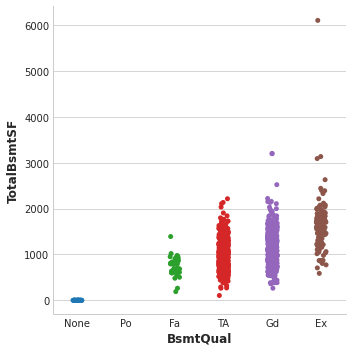

In [31]:
sns.catplot(x = "BsmtQual", y = "TotalBsmtSF",\
            data = df_train)

In [32]:
#display(df_train["OverallQual"].cat.codes.head())
#display(df_train["OverallCond"].cat.codes.head())

Here are some ideas for other transforms you could explore:
- Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between `BsmtQual` and `TotalBsmtSF`, for instance.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

## k-Means Clustering ##

The first unsupervised algorithm we used to create features was k-means clustering. We saw that you could either use the cluster labels as a feature (a column with `0, 1, 2, ...`) or you could use the *distance* of the observations to each cluster. We saw how these features can sometimes be effective at untangling complicated spatial relationships.

In [33]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##

PCA was the second unsupervised model we used for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm gave us *loadings* which described each component of variation, and also the *components* which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [34]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


And here are transforms that produce the features from the Exercise 5. You might want to change these if you came up with a different answer.


In [35]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


#pca_features = [
 #   "GarageArea",
  #  "YearRemodAdd",
   # "TotalBsmtSF",
    #"GrLivArea",
#]

### This is a cell I don't currently run.

X_pca = pca_components(df_train, cluster_features)
X1 = df_train.copy()
y = X1.pop("SalePrice")

mi_scores = make_mi_scores(X_pca, y)
mi_scores

In [36]:
def pca_components1(df, features):
    X = df.loc[:, features]
    pca, X_pca, _ = apply_pca(X)
    return pca, X_pca

### This is a cell I don't currently run.
pca, _ = pca_components1(df_train, cluster_features)
plot_variance(pca)

These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

Based on highest MI scores and on components with the most variance, it may be useful to do clustering with PC1 and PC2.

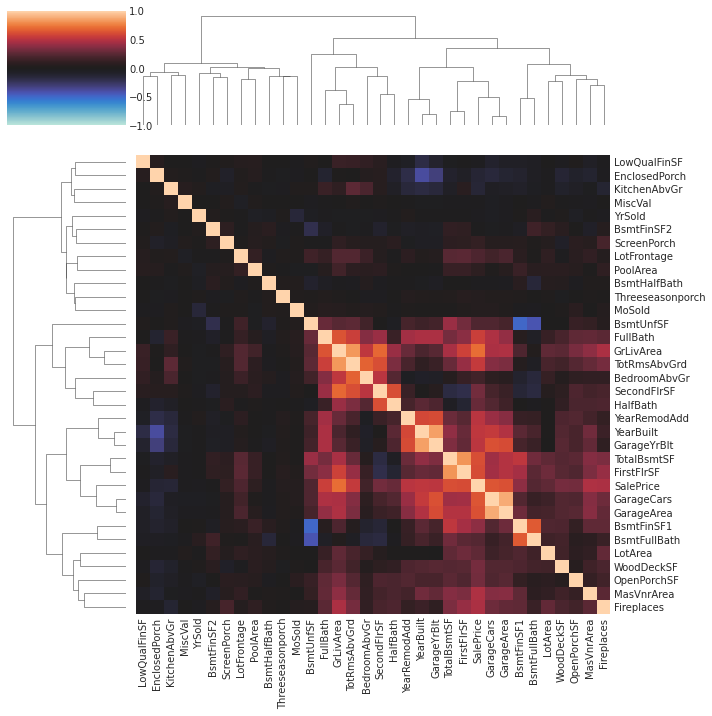

In [37]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

In [38]:
# These features were selected by myself, based on the corrplot above.
pca_features = ["BsmtUnfSF", "FullBath", "GrLivArea","TotRmsAbvGrd", \
               "YearRemodAdd", "YearBuilt", "GarageYrBlt",\
               "TotalBsmtSF", "FirstFlrSF", "GarageCars",\
               "BsmtFinSF1", "BsmtFullBath"]

PC1     0.878397
PC5     0.215645
PC2     0.182153
PC3     0.146871
PC4     0.099779
PC6     0.073958
PC7     0.065790
PC12    0.063813
PC11    0.062807
PC9     0.053690
PC8     0.028507
PC10    0.000000
Name: MI Scores, dtype: float64

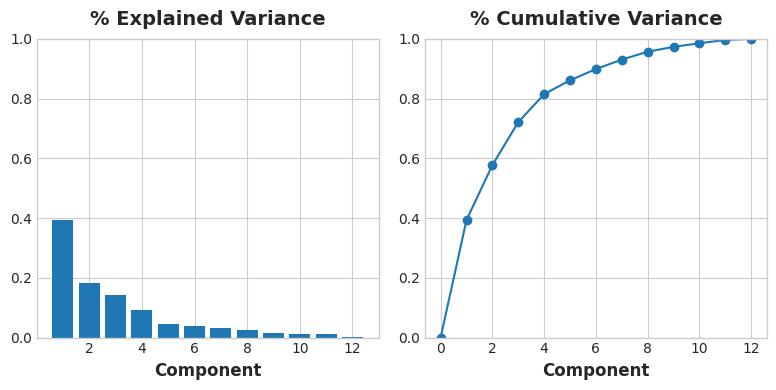

In [39]:
pca, X_pca = pca_components1(df_train, pca_features)
plot_variance(pca)
X1 = df_train.copy()
y = X1.pop("SalePrice")

mi_scores = make_mi_scores(X_pca, y)
mi_scores

Based on the group of features selected based on the corrlation matrix above, the first component PC1 has the highest MI score and captures the most variance.

Groups of highly correlated features often yield interesting loadings.

### PCA Application - Indicate Outliers ###

In Exercise 5, you applied PCA to determine houses that were **outliers**, that is, houses having values not well represented in the rest of the data. You saw that there was a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [40]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


You could also consider applying some sort of robust scaler from scikit-learn's `sklearn.preprocessing` module to the outlying values, especially those in `GrLivArea`. [Here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's [outlier detectors](https://scikit-learn.org/stable/modules/outlier_detection.html).

In [41]:
# I tried using sklearn IsolationForest to detect outliers. This feature
# did not improve the RMSLE and is not used in the create features function
# below.
from sklearn.ensemble import IsolationForest

def outliers(df):
    X = pd.DataFrame()
    isf = IsolationForest()
    X["Outliers"] = isf.fit(df[["GrLivArea"]])\
    .predict(df[["GrLivArea"]])
    return X

In [42]:
# I tried using sklearn PowerTransformer to help deal with outliers. 
# This feature did not improve the RMSLE and is not used in the create
# features function below.
from sklearn.preprocessing import PowerTransformer

def robust_scaler(df):
    pt = PowerTransformer()
    X = pd.DataFrame()
    X = pd.DataFrame(pt.fit_transform(df[["GrLivArea"]]))
    X.columns = ["GrLivAreaPT"]
    return X

In [43]:
# This is just used in order to view data transformed by the robust_scaler 
# function above.
X = robust_scaler(df_train)
X.head()
# len(X)

,GrLivAreaPT
0,0.528531
1,-0.382755
2,0.659112
3,0.540797
4,1.282894


## Target Encoding ##

Needing a separate holdout set to create a target encoding is rather wasteful of data. In *Tutorial 6* we used 25% of our dataset just to encode a single feature, `Zipcode`. The data from the other features in that 25% we didn't get to use at all.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper you can use with any target encoder:

In [44]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

You can turn any of the encoders from the [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/) library into a cross-fold encoder. The [`CatBoostEncoder`](http://contrib.scikit-learn.org/category_encoders/catboost.html) would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [45]:
def cluster_labels1(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    #X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [46]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    # Notice that I have added some mathematical transformations above.
    X = X.join(mathematical_transforms(X))
    # X = X.join(mathematical_transforms1(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # After trying for different number of components,
    # I chose to include the first six components.
    # X_pca = pca_components(X, pca_features).iloc[:,:1]
    X = X.join(pca_components(X, pca_features).iloc[:,:6])
    # X = X.join(indicate_outliers(X))
    # X = X.join(outliers(X))
    # X = X.join(robust_scaler(X))
    X = label_encode(X)
    
    # Filling missing values with 0 for the pca components that were included.
    X["PC1"].fillna(0, inplace = True)
    X["PC2"].fillna(0, inplace = True)
    X["PC3"].fillna(0, inplace = True)
    X["PC4"].fillna(0, inplace = True)
    X["PC5"].fillna(0, inplace = True)
    X["PC6"].fillna(0, inplace = True)
    # X["PC7"].fillna(0, inplace = True)
    
    # I included Clustering on PCA results with the first component only
    #X_pca = pca_components(X, pca_features)
    X = X.join(cluster_labels(X, ["PC1"], n_clusters=20))
    # X = X.join(cluster_distance(X, ["PC1"], n_clusters=20))

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    # I use CatBoostEncoder, which had similar results as the MEstimateEncoder,
    # at least for the parameters chosen as 'a=1', in comparison with 'm=1'
    # used for the MEstimateEncoder.
    encoder = CrossFoldEncoder(CatBoostEncoder, a=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.13707156833281423

# Step 4 - Hyperparameter Tuning #

At this stage, you might like to do some hyperparameter tuning with XGBoost before creating your final submission.

In [47]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

# The values of the parameters 'max_depth' and 'learning_rate' here 
# were selected based on the results of a run of RandomizedSearchCV below.
xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.0601,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12242729629858096

In [48]:
# The values of the parameters below were selected based on 
# the results of running BayesSearchCV below, WITHOUT
# specifying a SCORING method. The RMSLE gained with these parameters
# was WORSE than that gained with other parameters values, see above and below.

#OrderedDict([('colsample_bytree', 0.33031378603108447),
 #            ('learning_rate', 0.007130191055161543),
  #           ('max_depth', 5),
   #          ('min_child_weight', 3),
    #         ('n_estimators', 2797),
     #        ('num_parallel_tree', 1),
      #       ('reg_alpha', 3.576151522896895),
       #      ('reg_lambda', 3.801445342683552),
        #     ('subsample', 0.8458732968476645)])

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=5,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.007130191055161543,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=2797,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=3,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.33031378603108447,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.8458732968476645,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=3.576151522896895,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=3.801445342683552,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12762820701161942

In [49]:
# The values of the paramaters below were selected based on 
# running BayesSearchCV with scoring = 'neg_mean_squared_log_error'.

#('colsample_bytree', 0.46426138664317473),
 #            ('learning_rate', 0.03955829910880301),
  #           ('max_depth', 4),
   #          ('min_child_weight', 4),
    #         ('n_estimators', 3900),
     #        ('num_parallel_tree', 1),
      #       ('reg_alpha', 9.733199789995602),
       #      ('reg_lambda', 0.9766822781489516),
        #     ('subsample', 0.6357633933896558)])
                
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.03955829910880301,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=3900,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=4,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.46426138664317473,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.6357633933896558,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=9.733199789995602,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.9766822781489516,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.14372525612763679

The RMSLE gained with the parameters set as above was still higher than that gained for other parameter settings, see parameters settings above and below.

### I don't currently run this cell.
`from skopt import BayesSearchCV`
###### parameter ranges are specified by one of below
`from skopt.space import Real, Categorical, Integer`

###### log-uniform: understand as search over p = exp(x) by varying x
  `opt = BayesSearchCV(
     xgb,
     {
'max_depth': Integer(2,10),           # maximum depth of each tree - try 2 to 10
'learning_rate': Real(0.0001, 0.1),    # effect of each tree - try 0.0001 to 0.1
 'n_estimators': Integer(1000, 8000),     # number of trees (that is, boosting rounds) - try 1000 to 8000
'min_child_weight': Integer(1, 10),    # minimum number of houses in a leaf - try 1 to 10
    'colsample_bytree':Real(0.2,1),  # fraction of features (columns) per tree - try 0.2 to 1.0
    'subsample':Real(0.2,1),         # fraction of instances (rows) per tree - try 0.2 to 1.0
    'reg_alpha':Real(0.0, 10.0),         # L1 regularization (like LASSO) - try 0.0 to 10.0
    'reg_lambda':Real(0.0, 10.0),        # L2 regularization (like Ridge) - try 0.0 to 10.0
    'num_parallel_tree':Integer(1, 2),   # set > 1 for boosted random forests        
     },
     n_iter=32,
     random_state=0,
   scoring = 'neg_mean_squared_log_error'
 )`

 ###### executes bayesian optimization
`_ = opt.fit(X_train, y_train)`

 ###### model can be saved, used for predictions or scoring
###### print(opt.score(X_test, y_test))

###### Based on this run, opt's best params acheived are:
OrderedDict([('colsample_bytree', 0.33031378603108447),
            ('learning_rate', 0.007130191055161543),
            ('max_depth', 5),
          ('min_child_weight', 3),
         ('n_estimators', 2797),
             ('num_parallel_tree', 1),
            ('reg_alpha', 3.576151522896895),
           ('reg_lambda', 3.801445342683552),
          ('subsample', 0.8458732968476645)])

In [50]:
# opt.best_params_

Opt's best parameters gained were as follows -  

OrderedDict([('colsample_bytree', 0.46426138664317473),
             ('learning_rate', 0.03955829910880301),
             ('max_depth', 4),
             ('min_child_weight', 4),
             ('n_estimators', 3900),
             ('num_parallel_tree', 1),
             ('reg_alpha', 9.733199789995602),
             ('reg_lambda', 0.9766822781489516),
             ('subsample', 0.6357633933896558)])

In [51]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [52]:
# opt.best_params_

Opt's best parameters gained were as follows -  

OrderedDict([('colsample_bytree', 0.33031378603108447),
             ('learning_rate', 0.007130191055161543),
             ('max_depth', 5),
             ('min_child_weight', 3),
             ('n_estimators', 2797),
             ('num_parallel_tree', 1),
             ('reg_alpha', 3.576151522896895),
             ('reg_lambda', 3.801445342683552),
             ('subsample', 0.8458732968476645)])

In [53]:
# I don't currently run this cell.
#from sklearn.model_selection import RandomizedSearchCV
#clf = RandomizedSearchCV(xgb, param_grid, scoring = custom_scorer,\
 #                        random_state=0)
#clf = GridSearchCV(xgb, param_grid, scoring = custom_scorer)

# Be careful running the following line, it may require too much memory
#clf.fit(X_train, y_train)

In [54]:
# range(2,10)

In [55]:
param_grid = [
  {'max_depth': range(2,10),\
  'learning_rate': np.arange(0.0001, 0.1, 0.01),\
  'n_estimators': [1000],\
  'min_child_weight': [1],\
  'colsample_bytree': [0.2],\
  'subsample': [0.2],\
  'reg_alpha': [10],\
  'reg_lambda': [10],\
  'num_parallel_tree': [1]}
     ]
# Best Params gained based on this param_grid were:
#{'colsample_bytree': 0.2,
 #'learning_rate': 0.0001,
 #'max_depth': 2,
 #'min_child_weight': 1,
 #'n_estimators': 1000,
 #'num_parallel_tree': 1,
 #'reg_alpha': 10,
 #'reg_lambda': 10,
 #'subsample': 0.2}

#max_depth=6,           # maximum depth of each tree - try 2 to 10
 #   learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
  #  n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
   # min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    #colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    #subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    #reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    #reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    #num_parallel_tree=1,   # set > 1 for boosted random forests

In [56]:
from sklearn.metrics import make_scorer
custom_scorer = make_scorer(score_dataset, greater_is_better=False)

In [57]:
# I don't currently run this cell.
#from sklearn.model_selection import GridSearchCV
#xgb = XGBRegressor()
#clf = GridSearchCV(xgb, param_grid, scoring = custom_scorer)
# Be careful running this line, it may require too much memory
#clf.fit(X_train, y_train)

In [58]:
# clf.best_params_

Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic [hyperparameter tuners](https://scikit-learn.org/stable/modules/grid_search.html). Or you could explore more advanced tuning libraries like [Optuna](https://optuna.readthedocs.io/en/stable/index.html) or [scikit-optimize](https://scikit-optimize.github.io/stable/).

Here is how you can use Optuna with XGBoost:

```
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params
```

Copy this into a code cell if you'd like to use it, but be aware that it will take quite a while to run. After it's done, you might enjoy using some of [Optuna's visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

In [59]:
# xgb_params

In [60]:
# The following parameters were obtained with optuna, and they are the ones
# I currently use in my model.
xgb_params = {'max_depth': 8,
 'learning_rate': 0.0030979892591252315,
 'n_estimators': 4814,
 'min_child_weight': 2,
 'colsample_bytree': 0.2996065054377571,
 'subsample': 0.7019237898243325,
 'reg_alpha': 0.13988814702458416,
 'reg_lambda': 0.011516065272666812}

In [61]:
xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.11828619528482935

### I don't currently run this cell.
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

###### log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

### I don't currently run this cell.
`import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params`

### I don't currently run this cell.
`from skopt import BayesSearchCV
###### parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     train_size=0.75,
                                                     random_state=0)

###### log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
     SVC(),
     {
         'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
         'degree': Integer(1,8),
         'kernel': Categorical(['linear', 'poly', 'rbf']),
    },
     n_iter=32,
     random_state=0
 )

###### executes bayesian optimization
_ = opt.fit(X_train, y_train)

###### model can be saved, used for predictions or scoring
print(opt.score(X_test, y_test))`

### I don't currently run this cell.
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

###### Next, we need to define the bounds of the dimensions of the search space we want to explore and pick the objective. In this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters.

from skopt.space import Real, Integer
from skopt.utils import use_named_args


###### The list of hyper-parameters we want to optimize. For each one we define the
###### bounds, the corresponding scikit-learn parameter name, as well as how to
###### sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

###### this decorator allows your objective function to receive a the parameters as
###### keyword arguments. This is particularly convenient when you want to set
###### scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

###### Optimize all the things!
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

Out:

'Best score=2.9593'

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))

from skopt.plots import plot_convergence

plot_convergence(res_gp)

### I don't currently run this cell.
`from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
display(plot_optimization_history(study))
display(plot_intermediate_values(study))
display(plot_parallel_coordinate(study))
display(plot_contour(study))
display(plot_slice(study))
display(plot_param_importances(study))
display(plot_edf(study))`

# Step 5 - Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- create your feature set from the original data
- train XGBoost on the training data
- use the trained model to make predictions from the test set
- save the predictions to a CSV file

In [62]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*